# XGBoost Regressor with lag features

### Import data and libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv("data/full.csv")
oil_df = pd.read_csv("data/oil.csv")
promo_elasticity_df = pd.read_csv("data/promotion_elasticity.csv")
oil_elasticity_df = pd.read_csv("data/oil_elasticity.csv")
df["date"] = pd.to_datetime(df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])

In [4]:
def create_time_features(df):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["week"] = df["date"].dt.isocalendar().week.astype("int32")
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.dayofweek
    return df

def pattern_plot(pattern_df, period):
    pattern_period = pattern_df.groupby(["year", period])["sales"].sum().reset_index()
    sns.lineplot(pattern_period, x=period, y="sales", hue="year")
    
def train_xgb(train, test, features, target, n_estimators, md, lr, early): 
    X_train = train[features]
    X_train = pd.get_dummies(X_train)
    y_train = train[target]

    X_test = test[features]
    X_test = pd.get_dummies(X_test)
    y_test = test[target]

    xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                    n_estimators=n_estimators,
                    early_stopping_rounds=early,
                    objective='reg:squarederror',
                    max_depth=md,
                    learning_rate=lr)
    xgb_model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    return xgb_model

def check_predictions(train, test, features, xgb_model):
    family_prediction = pd.DataFrame()
    test = test.copy()
    X_test = test[features]
    X_test = pd.get_dummies(X_test)
    average_sales = train.groupby("family")["sales"].mean()
    std_sales = train.groupby("family")["sales"].std()
    
    test["prediction"] = xgb_model.predict(X_test)
    test["mae"] = np.abs(test["sales"] - test["prediction"])
    
    family_prediction["avg_mae"] = test.groupby("family")["mae"].mean()
    family_prediction["pct_avg_sales"] = family_prediction["avg_mae"] / average_sales
    family_prediction["std_diff"] = family_prediction["avg_mae"] / std_sales
    family_prediction["worth_to_predict"] = family_prediction["std_diff"] < 1
    
    return (test, family_prediction)

def visualize_prediction(df, family, store_nbr):
    fig, ax = plt.subplots(figsize=(15, 5))
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="sales", label='Real value', title=f'{family}({store_nbr}): Real / Predicted value')
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="prediction", label='Predicted value')
    ax.legend(['Real value', 'Predicted value'])
    plt.show()
    df[df["family"]==family].plot.scatter(x="sales", y="prediction")

In [5]:
df = create_time_features(df)

### Patterns

In [64]:
plot_df = df.loc[df["year"] < 2017]

### Month

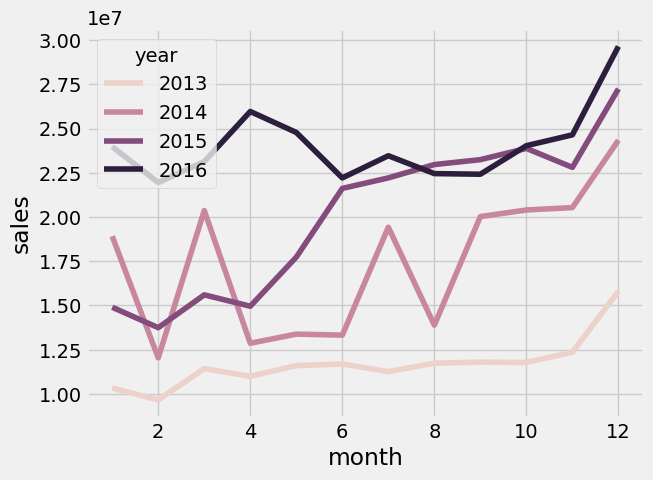

In [65]:
pattern_plot(plot_df, "month")

### Week

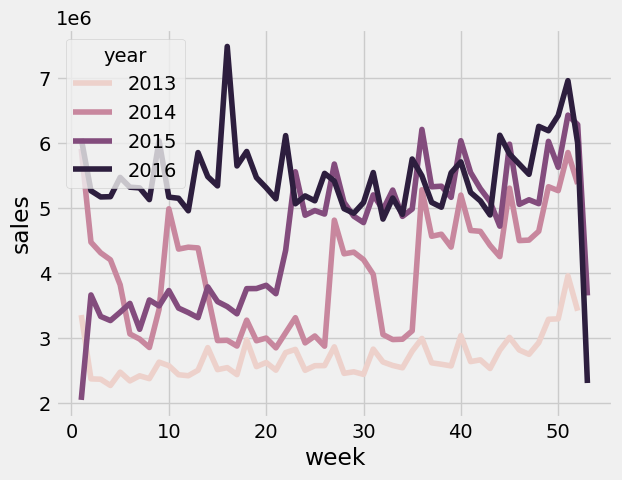

In [66]:
pattern_plot(plot_df, "week")

### Day

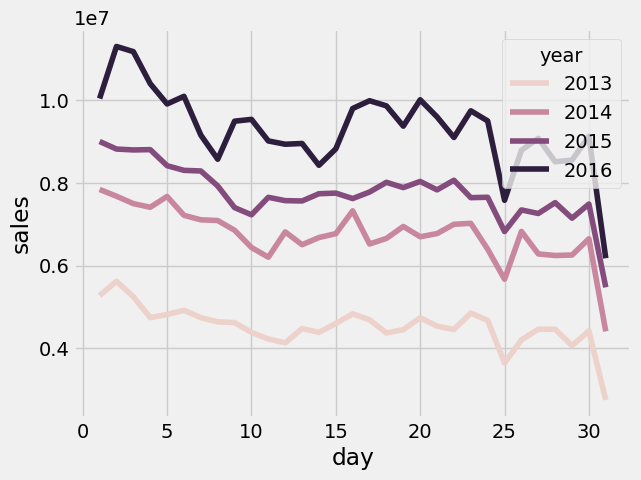

In [67]:
pattern_plot(plot_df, "day")

### Day of week

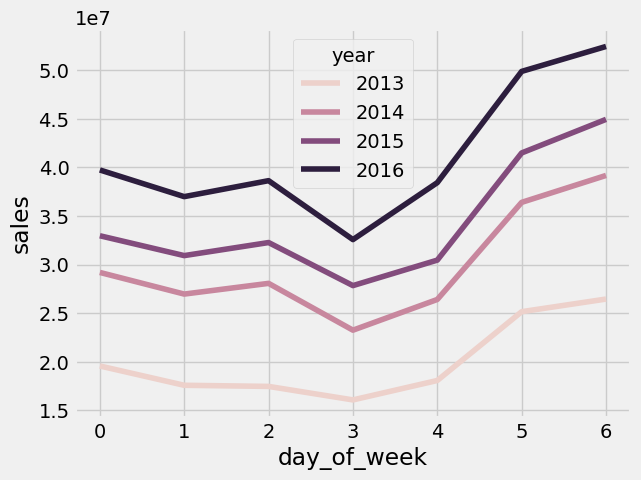

In [68]:
pattern_plot(plot_df, "day_of_week")

## Adding the lag features

In [6]:
df["lag_1m"] = df.groupby(["store_nbr", "family"])["sales"].shift(periods=31)
df["lag_1w"] = df.groupby(["store_nbr", "family"])["sales"].shift(periods=7)

### Predicting 1 month

In [7]:
df = df.dropna()

In [8]:
def get_month_week_train_test(df):
    month_date = df.iloc[-1]["date"] - pd.Timedelta("31 days")
    train_month = df.loc[df.date <= month_date]
    test_month = df.loc[df.date > month_date]

    week_date = df.iloc[-1]["date"] - pd.Timedelta("7 days")
    train_week = df.loc[df.date <= week_date]
    test_week = df.loc[df.date > week_date]
    
    return (train_month, test_month, train_week, test_week)

In [9]:
train_month, test_month, train_week, test_week = get_month_week_train_test(df)

In [10]:
month_features = ["store_nbr", "family", "onpromotion", "is_holiday", "type", "year", "month", "week", "day", "day_of_week", "lag_1m"]
week_features = ["store_nbr", "family", "onpromotion", "is_holiday", "type", "year", "month", "week", "day", "day_of_week", "lag_1m", "lag_1w"]
target = "sales"

In [111]:
xgb_month = train_xgb(train_month, test_month, month_features, target, 1000, 6, 0.03, 50)
xgb_week = train_xgb(train_week, test_week, week_features, target, 1000, 6, 0.03, 50)

[0]	validation_0-rmse:1132.28800	validation_1-rmse:1327.04596
[100]	validation_0-rmse:379.38700	validation_1-rmse:317.95876
[200]	validation_0-rmse:337.17875	validation_1-rmse:298.38509
[300]	validation_0-rmse:313.93260	validation_1-rmse:292.20497
[400]	validation_0-rmse:299.89251	validation_1-rmse:287.99739
[500]	validation_0-rmse:288.33745	validation_1-rmse:282.56917
[600]	validation_0-rmse:280.55128	validation_1-rmse:277.84088
[700]	validation_0-rmse:273.13105	validation_1-rmse:274.43257
[800]	validation_0-rmse:266.78630	validation_1-rmse:270.92380
[900]	validation_0-rmse:261.04283	validation_1-rmse:267.79596
[999]	validation_0-rmse:256.30257	validation_1-rmse:265.46513
[0]	validation_0-rmse:1133.57582	validation_1-rmse:1187.52668
[100]	validation_0-rmse:304.29664	validation_1-rmse:240.93651
[168]	validation_0-rmse:277.57786	validation_1-rmse:242.19118


In [119]:
test_month, family_month = check_predictions(train_month, test_month, month_features, xgb_month)
test_week, family_week = check_predictions(train_week, test_week, week_features, xgb_week)

In [123]:
family_month["pct_avg_sales"].sort_values()[:5]


family
GROCERY I       0.151715
DAIRY           0.189765
BREAD/BAKERY    0.196640
DELI            0.221329
POULTRY         0.228076
Name: pct_avg_sales, dtype: float64

In [124]:
family_week["pct_avg_sales"].sort_values()[:5]


family
DAIRY           0.142453
GROCERY I       0.153961
BREAD/BAKERY    0.159665
POULTRY         0.167110
MEATS           0.178235
Name: pct_avg_sales, dtype: float64

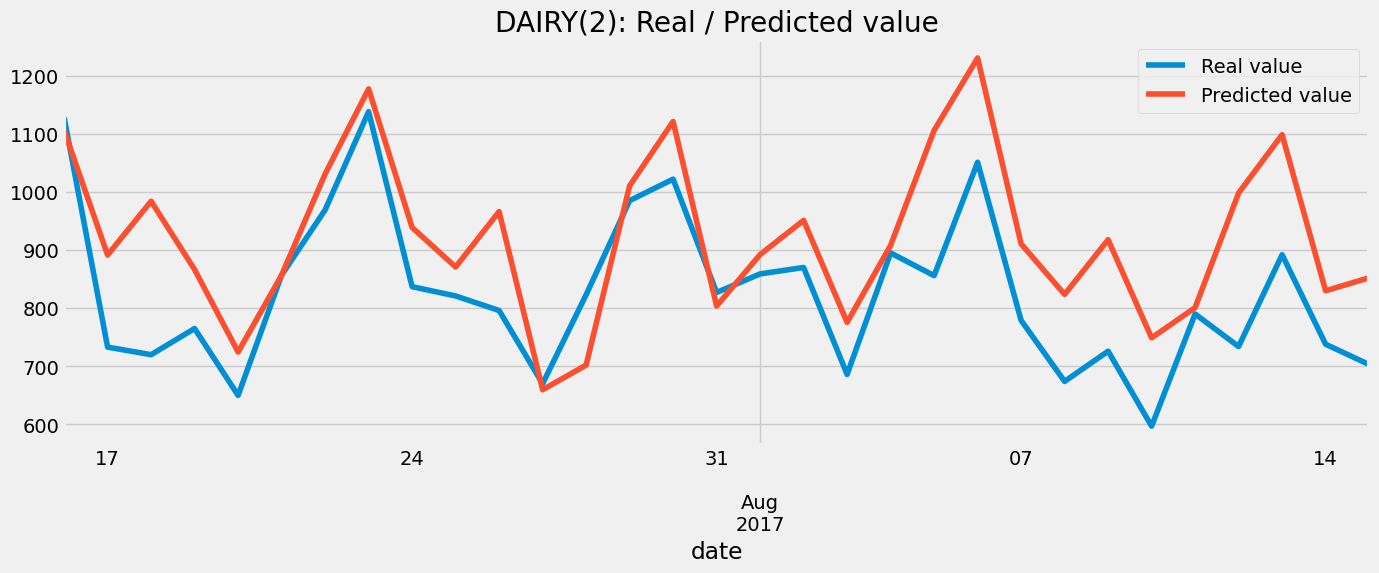

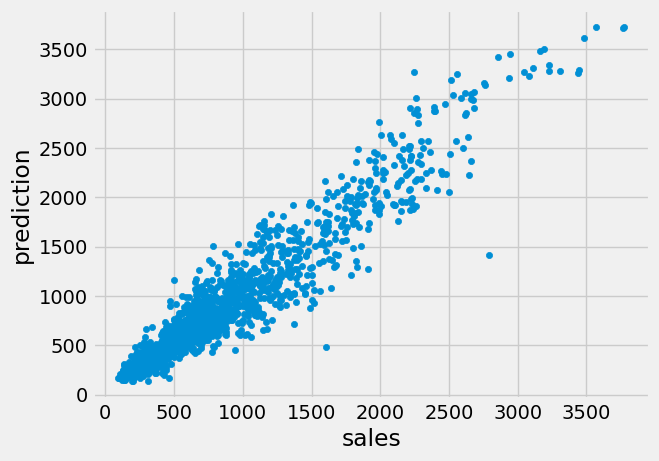

In [150]:
visualize_prediction(test_month, "DAIRY", 2)

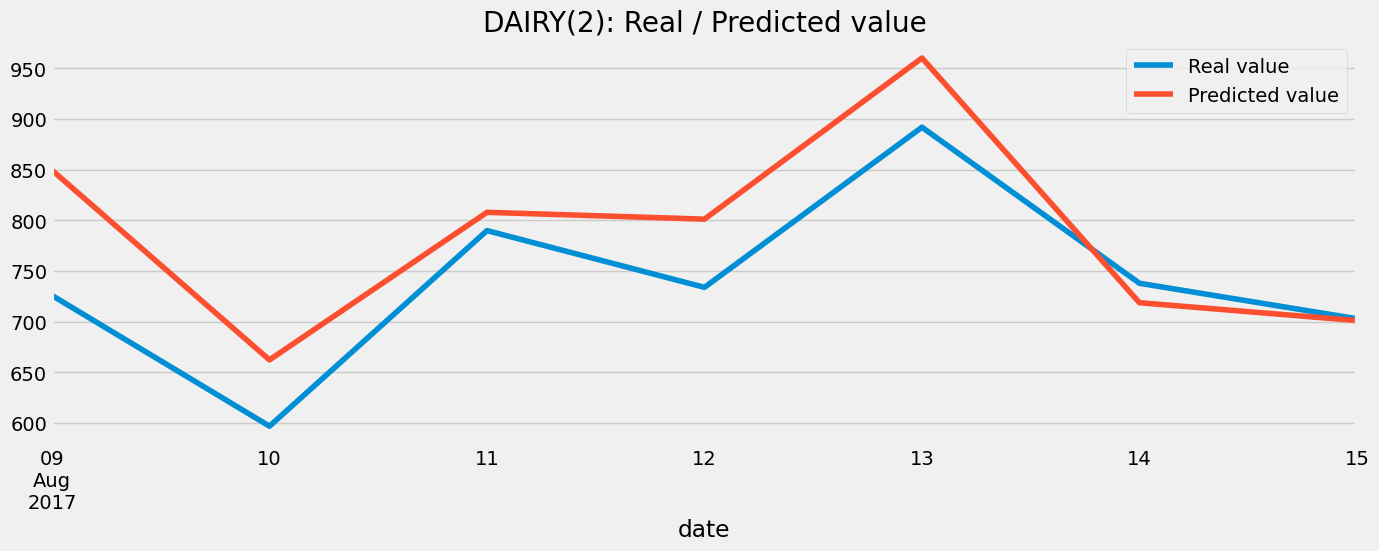

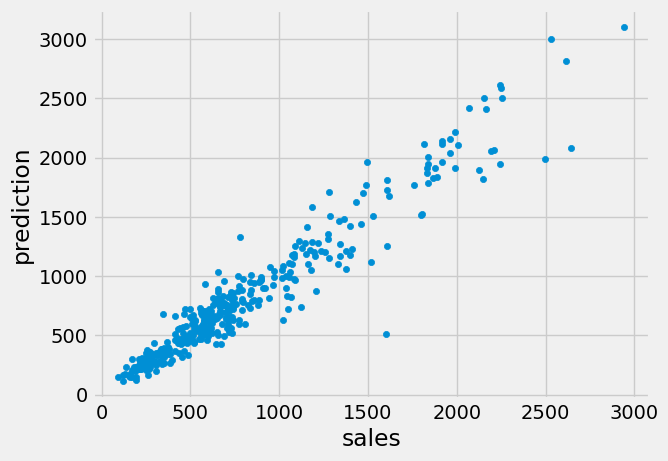

In [147]:
visualize_prediction(test_week, "DAIRY", 2)

In [11]:
df_oil = pd.merge(df, oil_df, on="date", how="left")
df_oil = df_oil.fillna(method="ffill")
df_oil["bigger_70"] = df_oil["dcoilwtico"] > 70

In [12]:
train_oil_month, test_oil_month, train_oil_week, test_oil_week = get_month_week_train_test(df_oil)

In [13]:
oil_month_features = ["store_nbr", "family", "onpromotion", "is_holiday", "type", "year", "month", "week", "day", "day_of_week", "lag_1m", "bigger_70"]
oil_week_features = ["store_nbr", "family", "onpromotion", "is_holiday", "type", "year", "month", "week", "day", "day_of_week", "lag_1m", "lag_1w", "bigger_70"]
target = "sales"
xgb_oil_month = train_xgb(train_oil_month, test_oil_month, oil_month_features, target, 1000, 6, 0.03, 50)
xgb_oil_week = train_xgb(train_oil_week, test_oil_week, oil_week_features, target, 1000, 6, 0.03, 50)

[0]	validation_0-rmse:999.29040	validation_1-rmse:1206.44219
[100]	validation_0-rmse:346.15499	validation_1-rmse:286.20108
[200]	validation_0-rmse:310.57169	validation_1-rmse:254.21201
[300]	validation_0-rmse:290.35770	validation_1-rmse:246.87562
[400]	validation_0-rmse:277.42816	validation_1-rmse:240.89419
[500]	validation_0-rmse:265.82332	validation_1-rmse:235.75610
[600]	validation_0-rmse:257.96392	validation_1-rmse:233.10541
[700]	validation_0-rmse:251.75868	validation_1-rmse:230.97353
[800]	validation_0-rmse:245.56275	validation_1-rmse:229.09959
[900]	validation_0-rmse:240.61519	validation_1-rmse:227.80867
[999]	validation_0-rmse:236.44975	validation_1-rmse:226.45690
[0]	validation_0-rmse:1001.02190	validation_1-rmse:1142.76929
[100]	validation_0-rmse:286.66985	validation_1-rmse:221.92785
[200]	validation_0-rmse:255.89883	validation_1-rmse:209.85179
[300]	validation_0-rmse:244.99624	validation_1-rmse:206.31318
[400]	validation_0-rmse:234.31704	validation_1-rmse:203.71563
[500]	val

In [14]:
test_oil_month, family_oil_month = check_predictions(train_oil_month, test_oil_month, oil_month_features, xgb_oil_month)
test_oil_week, family_oil_week = check_predictions(train_oil_week, test_oil_week, oil_week_features, xgb_oil_week)

In [15]:
family_oil_month["pct_avg_sales"].sort_values()[:5]


family
GROCERY I       0.139075
DAIRY           0.171746
BREAD/BAKERY    0.184478
POULTRY         0.222292
PRODUCE         0.229120
Name: pct_avg_sales, dtype: float64

In [16]:
family_oil_week["pct_avg_sales"].sort_values()[:5]


family
DAIRY           0.123963
GROCERY I       0.130914
DELI            0.157600
BREAD/BAKERY    0.170902
POULTRY         0.171474
Name: pct_avg_sales, dtype: float64

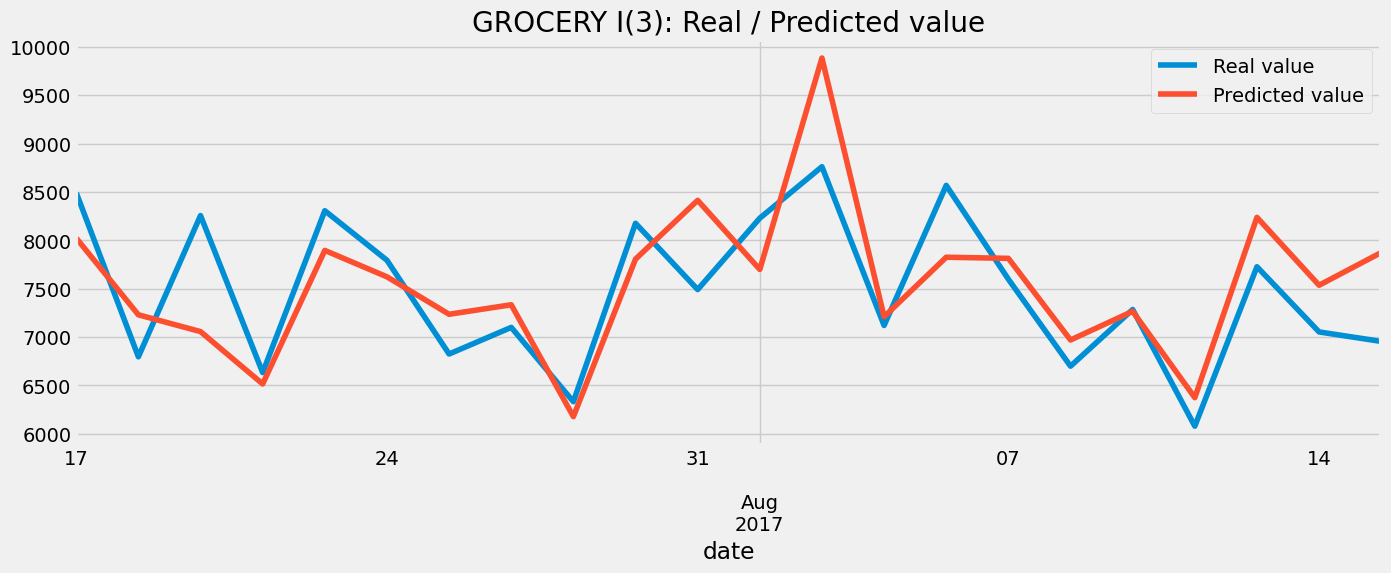

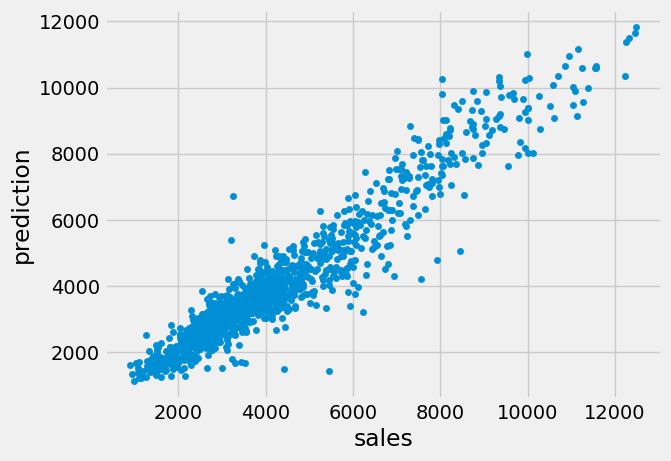

In [29]:
visualize_prediction(test_oil_month, "GROCERY I", 3)


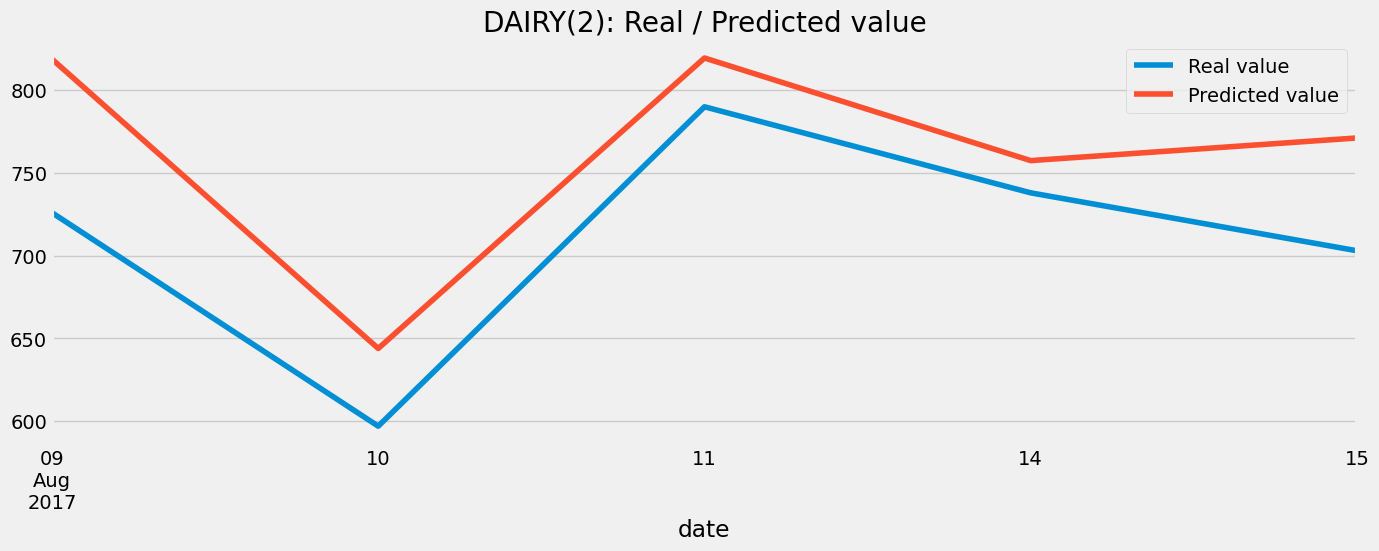

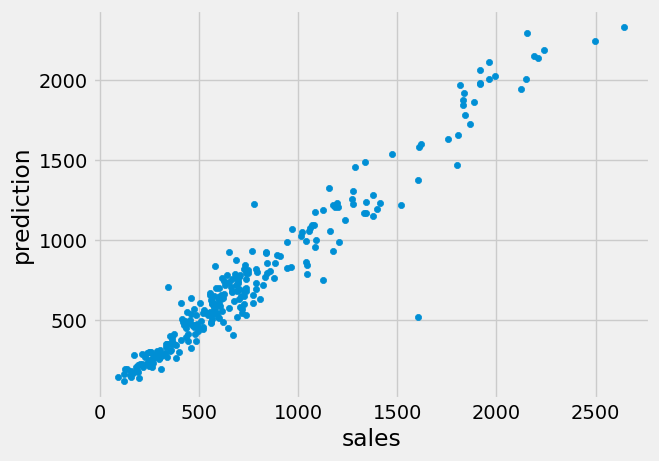

In [30]:
visualize_prediction(test_oil_week, "DAIRY", 2)

In [31]:
family_oil_week

,avg_mae,pct_avg_sales,std_diff,worth_to_predict
family,,,,
AUTOMOTIVE,4.199634,0.794427,0.789146,True
BABY CARE,2.280298,21.988585,3.250174,False
BEAUTY,5.508563,1.767020,1.436793,False
BEVERAGES,481.951748,0.229309,0.258635,True
BOOKS,2.216047,31.711359,4.053876,False
BREAD/BAKERY,71.847106,0.170902,0.229301,True
CELEBRATION,7.803739,0.997257,0.552762,True
CLEANING,196.953820,0.203466,0.321159,True
DAIRY,79.101879,0.123963,0.139301,True
